In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
# Load the bike trip data from CSV file
df = pd.read_csv("clean_data.csv", parse_dates=['starttime','stoptime'])
df.head()

,ID,tripduration,starttime,stoptime,ss_id,ss_name,ss_latitude,ss_longitude,es_id,es_name,es_latitude,es_longitude,bikeid,usertype,birth year,gender
0,0,695,2013-06-01 00:00:00,2013-06-01 00:11:00,444,Broadway & W 24 St,40.742354,-73.989151,434,9 Ave & W 18 St,40.743174,-74.003664,19678,Subscriber,1983,1
1,1,693,2013-06-01 00:00:00,2013-06-01 00:11:00,444,Broadway & W 24 St,40.742354,-73.989151,434,9 Ave & W 18 St,40.743174,-74.003664,16649,Subscriber,1984,1
2,2,2059,2013-06-01 00:00:00,2013-06-01 00:35:00,406,Hicks St & Montague St,40.695128,-73.995951,406,Hicks St & Montague St,40.695128,-73.995951,19599,Customer,0,0
3,3,123,2013-06-01 00:01:00,2013-06-01 00:03:00,475,E 15 St & Irving Pl,40.735243,-73.987586,262,Washington Park,40.691782,-73.973730,16352,Subscriber,1960,1
4,4,1521,2013-06-01 00:01:00,2013-06-01 00:26:00,2008,Little West St & 1 Pl,40.705693,-74.016777,310,State St & Smith St,40.689269,-73.989129,15567,Subscriber,1983,1


In [3]:
df.count()

ID              577703
tripduration    577703
starttime       577703
stoptime        577703
ss_id           577703
ss_name         577703
ss_latitude     577703
ss_longitude    577703
es_id           577703
es_name         577703
es_latitude     577703
es_longitude    577703
bikeid          577703
usertype        577703
birth year      577703
gender          577703
dtype: int64

In [4]:
# Drop irrelevant columns
df = df.drop(['ID', 'bikeid', 'usertype', 'birth year', 'gender','es_id'], axis=1)

# Set the index to the starttime column
df = df.set_index('starttime')
# Aggregate the data by hour and station
df = df.resample('H').agg({'tripduration': 'count', 'ss_id': 'nunique'})

In [5]:
df.head()

,tripduration,ss_id
starttime,,
2013-06-01 00:00:00,152,101
2013-06-01 01:00:00,102,74
2013-06-01 02:00:00,67,52
2013-06-01 03:00:00,41,32
2013-06-01 04:00:00,16,15


In [6]:
df.count()

tripduration    721
ss_id           721
dtype: int64

<Axes: xlabel='starttime'>

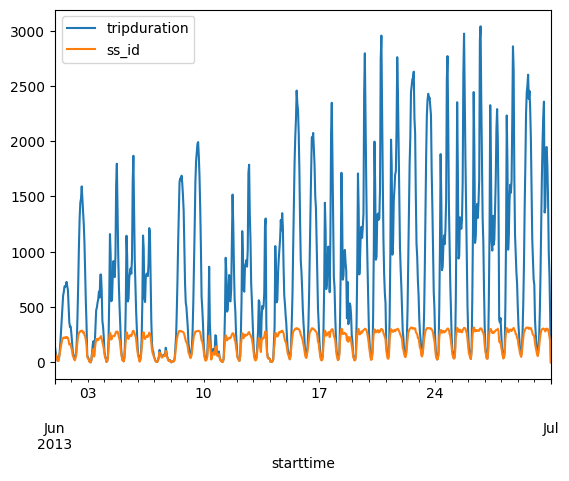

In [7]:
df.plot()

In [8]:
# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train_data, test_data = df[0:train_size], df[train_size:len(df)]

In [9]:
print(test_data.shape)
print(train_data.shape)

(145, 2)
(576, 2)


In [10]:
# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train_data, test_data = df[0:train_size], df[train_size:len(df)]

In [11]:
from sklearn.preprocessing import StandardScaler

# Normalize the data using MinMaxScaler
scaler = StandardScaler()
scaler = scaler.fit(train_data[['tripduration','ss_id']])

train_data[['tripduration','ss_id']] = scaler.transform(train_data[['tripduration','ss_id']])
test_data[['tripduration','ss_id']] = scaler.transform(test_data[['tripduration','ss_id']])

C:\Users\Rahul\AppData\Local\Temp\ipykernel_9400\3533000856.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[['tripduration','ss_id']] = scaler.transform(train_data[['tripduration','ss_id']])
C:\Users\Rahul\AppData\Local\Temp\ipykernel_9400\3533000856.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[['tripduration','ss_id']] = scaler.transform(test_data[['tripduration','ss_id']])


In [12]:
train_data

,tripduration,ss_id
starttime,,
2013-06-01 00:00:00,-0.827179,-0.788981
2013-06-01 01:00:00,-0.900252,-1.059388
2013-06-01 02:00:00,-0.951404,-1.279719
2013-06-01 03:00:00,-0.989402,-1.480020
2013-06-01 04:00:00,-1.025939,-1.650276
...,...,...
2013-06-24 19:00:00,2.108922,1.264105
2013-06-24 20:00:00,1.046430,1.143924
2013-06-24 21:00:00,0.524684,0.793397


In [13]:
#create time sequence data
def create_sequences(X,y, time_steps):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

In [14]:
seq_length = 24 # number of hours in a day
train_X, train_y = create_sequences(train_data[['tripduration']],train_data[['ss_id']], seq_length)
test_X, test_y = create_sequences(test_data[['tripduration']],test_data[['ss_id']], seq_length)

In [15]:
print(train_X.shape)
train_y.shape

(552, 24, 1)


(552, 1)

In [16]:
print(test_X.shape)
test_y.shape

(121, 24, 1)


(121, 1)

In [17]:
# define the model architecture
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(1)))

# compile the model
model.compile(optimizer='adam', loss='mae')


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 24, 128)           0         
                                                                 
 time_distributed (TimeDistr  (None, 24, 64)           8256      
 ibuted)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 24, 64)            0         
                                                                 
 time_distributed_1 (TimeDis  (None, 24, 1)            65        
 tributed)                                                       
                                                                 
Total params: 74,881
Trainable params: 74,881
Non-traina

In [19]:
# train the model
history = model.fit(train_X, train_y, epochs=20, batch_size=2, validation_split=0.1, shuffle=False)

Epoch 1/20
248/248 [==============================] - 9s 19ms/step - loss: 0.8881 - val_loss: 0.7335
Epoch 2/20
248/248 [==============================] - 4s 15ms/step - loss: 0.8746 - val_loss: 0.7107
Epoch 3/20
248/248 [==============================] - 4s 16ms/step - loss: 0.8615 - val_loss: 0.6796
Epoch 4/20
248/248 [==============================] - 4s 16ms/step - loss: 0.8412 - val_loss: 0.5759
Epoch 5/20
248/248 [==============================] - 4s 16ms/step - loss: 0.8360 - val_loss: 0.5887
Epoch 6/20
248/248 [==============================] - 4s 15ms/step - loss: 0.8724 - val_loss: 0.6264
Epoch 7/20
248/248 [==============================] - 4s 15ms/step - loss: 0.8289 - val_loss: 0.5635
Epoch 8/20
248/248 [==============================] - 5s 19ms/step - loss: 0.8201 - val_loss: 0.5332
Epoch 9/20
248/248 [==============================] - 5s 22ms/step - loss: 0.7997 - val_loss: 0.5205
Epoch 10/20
248/248 [==============================] - 6s 23ms/step - loss: 0.7937 - val_lo

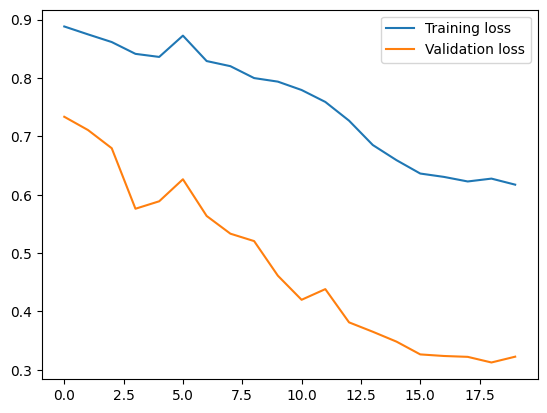

In [20]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [21]:
model.evaluate(test_X, test_y)

4/4 [==============================] - 1s 15ms/step - loss: 0.2795


0.27952414751052856

Reconstruction error threshold: 1.7259657705867977


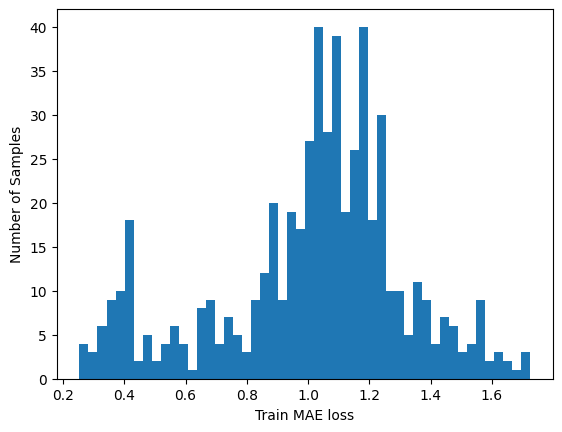

In [22]:
X_train_pred = model.predict(train_X, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - train_X), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

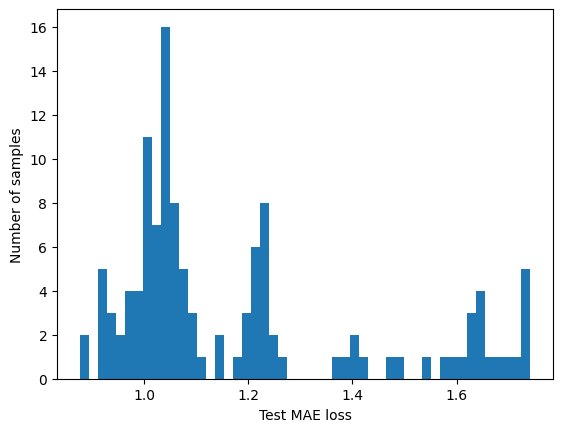

In [23]:
X_test_pred = model.predict(test_X, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-test_X), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

In [24]:
test_score_df = pd.DataFrame(test_data[seq_length:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['tripduration'] = test_data[seq_length:]['tripduration']
test_score_df['ss_id'] = test_data[seq_length:]['ss_id']

In [25]:
test_score_df.tail()

,tripduration,ss_id,loss,threshold,anomaly
starttime,,,,,
2013-06-30 20:00:00,1.084429,1.194000,0.989612,1.725966,False
2013-06-30 21:00:00,0.397536,0.853488,0.976673,1.725966,False
2013-06-30 22:00:00,0.096472,0.543021,0.973178,1.725966,False
2013-06-30 23:00:00,-0.423812,0.082329,0.975272,1.725966,False
2013-07-01 00:00:00,-1.047861,-1.790486,0.990913,1.725966,False


In [26]:
# Interactive chart (plotly): Test Loss & Treshold

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df.index, y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df.index, y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [27]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.head()

,tripduration,ss_id,loss,threshold,anomaly
starttime,,,,,
2013-06-27 01:00:00,-0.843255,-0.809011,1.735922,1.725966,True
2013-06-27 02:00:00,-0.930943,-1.159538,1.735984,1.725966,True
2013-06-30 03:00:00,-0.793565,-0.758936,1.742191,1.725966,True
2013-06-30 04:00:00,-0.894407,-1.049372,1.739179,1.725966,True


In [28]:
anomalies.shape

(4, 5)

In [29]:
starttime=test_score_df.index

In [30]:
starttime

DatetimeIndex(['2013-06-26 00:00:00', '2013-06-26 01:00:00',
               '2013-06-26 02:00:00', '2013-06-26 03:00:00',
               '2013-06-26 04:00:00', '2013-06-26 05:00:00',
               '2013-06-26 06:00:00', '2013-06-26 07:00:00',
               '2013-06-26 08:00:00', '2013-06-26 09:00:00',
               ...
               '2013-06-30 15:00:00', '2013-06-30 16:00:00',
               '2013-06-30 17:00:00', '2013-06-30 18:00:00',
               '2013-06-30 19:00:00', '2013-06-30 20:00:00',
               '2013-06-30 21:00:00', '2013-06-30 22:00:00',
               '2013-06-30 23:00:00', '2013-07-01 00:00:00'],
              dtype='datetime64[ns]', name='starttime', length=121, freq='H')

In [31]:
# Interactive chart (plotly): timeseries & Anomalies

test_trans=pd.DataFrame(scaler.inverse_transform(test_score_df[['tripduration','ss_id']]),columns=['tripduration','ss_id'])
anamolies_tr=pd.DataFrame(scaler.inverse_transform(test_score_df[['tripduration','ss_id']]),columns=['tripduration','ss_id'])


In [32]:
test_trans

,tripduration,ss_id
0,271.0,142.0
1,135.0,83.0
2,88.0,65.0
3,57.0,39.0
4,33.0,30.0
...,...,...
116,1460.0,299.0
117,990.0,265.0
118,784.0,234.0
119,428.0,188.0


In [33]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df.index, y=test_trans['ss_id'], name='Tripduration'))
fig.add_trace(go.Scatter(x=anomalies.index, y=anamolies_tr['ss_id'], mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()

Test

In [ ]:
df_test = pd.read_csv("clean_data1.csv", parse_dates=['starttime','stoptime'])
df_test.head()

In [ ]:
df_test.count()

In [ ]:
# Drop irrelevant columns
df_test = df_test.drop(['ID', 'bikeid', 'usertype', 'birth year', 'gender','es_id'], axis=1)

# Set the index to the starttime column
df_test = df_test.set_index('starttime')
# Aggregate the data by hour and station
df_test = df_test.resample('H').agg({'tripduration': 'count', 'ss_id': 'nunique'})



In [ ]:
df_test.plot()

In [ ]:
from sklearn.preprocessing import StandardScaler

# Normalize the data using MinMaxScaler
scaler = StandardScaler()
scaler = scaler.fit(df_test[['tripduration','ss_id']])

df_test[['tripduration','ss_id']] = scaler.transform(df_test[['tripduration','ss_id']])

In [ ]:
df_test

In [ ]:
seq_length = 24 # number of hours in a day
test1_X, test1_y = create_sequences(df_test[['tripduration']],df_test[['ss_id']], seq_length)

In [ ]:
model.evaluate(test1_X, test1_y)

In [ ]:
X_test1_pred = model.predict(test1_X, verbose=0)
test1_mae_loss = np.mean(np.abs(X_test1_pred- test1_X), axis=1)

plt.hist(test1_mae_loss , bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of Samples');

threshold1 = np.max(test1_mae_loss )
print(f'Reconstruction error threshold: {threshold1}')

In [ ]:
test1_score_df = pd.DataFrame(df_test[seq_length:])
test1_score_df['loss'] = test1_mae_loss
test1_score_df['threshold'] = threshold1
test1_score_df['anomaly'] = test1_score_df['loss'] > test1_score_df['threshold']
test1_score_df['tripduration'] = df_test[seq_length:]['tripduration']
test1_score_df['ss_id'] = df_test[seq_length:]['ss_id']

In [ ]:
test1_score_df.tail()

In [ ]:
# Interactive chart (plotly): Test Loss & Treshold

fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=test1_score_df.index, y=test1_score_df['loss'], name='Test loss'))
fig1.add_trace(go.Scatter(x=test1_score_df.index, y=test1_score_df['threshold'], name='Threshold'))
fig1.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig1.show()

In [ ]:
anomalies1 = test1_score_df.loc[test1_score_df['anomaly'] == True]
anomalies1.head()

In [ ]:
starttime1=test1_score_df.index

In [ ]:
# Interactive chart (plotly): timeseries & Anomalies

test1_trans=pd.DataFrame(scaler.inverse_transform(test1_score_df[['tripduration','ss_id']]),columns=['tripduration','ss_id'])
anamolies1_tr=pd.DataFrame(scaler.inverse_transform(test1_score_df[['tripduration','ss_id']]),columns=['tripduration','ss_id'])


In [ ]:
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=test1_score_df.index, y=test1_trans['ss_id'], name='Tripduration'))
fig1.add_trace(go.Scatter(x=anomalies1.index, y=anamolies1_tr['ss_id'], mode='markers', name='Anomaly'))
fig1.update_layout(showlegend=True, title='Detected anomalies')
fig1.show()